# Validating Sinkhorn Divergence Against LP Ground Truth

This notebook samples Gaussian mixture problems and compares the Sinkhorn divergence implementation against exact transport costs obtained from the linear programming (LP) solver.

## Experiment plan
- draw multiple 2D Gaussian mixture pairs on a regular grid;
- solve each problem with the LP solver to obtain the unregularized $W_2^2$ cost;
- evaluate `sinkhorn_divergence_with_solver` for several regularization parameters;
- compare the divergence estimate against the LP ground truth with tables and plots.

In [ ]:
import sys, os
from jax import config

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
config.update("jax_enable_x64", True)
sys.path.insert(0, os.path.abspath(os.path.join("..")))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from uot.utils.costs import cost_euclid_squared
from uot.problems.generators import GaussianMixtureGenerator
from uot.solvers.linear_programming import LinearProgrammingTwoMarginalSolver
from uot.solvers.sinkhorn import sinkhorn_divergence_with_solver
from uot.data.measure import DiscreteMeasure

plt.style.use("white")


## Problem generator and solver helpers
We keep everything on a modest 2D grid so that both LP and Sinkhorn runs remain inexpensive while still showing the effect of the Sinkhorn regularization.

In [ ]:
def to_discrete_np(measure):
    """Return points & weights as NumPy arrays without zero-mass entries."""
    pts, weights = measure.to_discrete(include_zeros=False)
    return np.asarray(pts, dtype=np.float64), np.asarray(weights, dtype=np.float64)

experiment_config = dict(
    dim=1,
    num_components=4,
    n_points=512,
    num_datasets=30,
    borders=(-1.0, 1.0),
    seed=48,
)

regs = [1e-4, 1e-3, 5e-2, 1e-2, 1e-1]
sinkhorn_kwargs = dict(maxiter=5000, tol=1e-6)

generator = GaussianMixtureGenerator(
    name="gmm-2d-validation",
    dim=experiment_config["dim"],
    num_components=experiment_config["num_components"],
    n_points=experiment_config["n_points"],
    num_datasets=experiment_config["num_datasets"],
    borders=experiment_config["borders"],
    cost_fn=cost_euclid_squared,
    use_jax=False,
    measure_mode="grid",
    seed=experiment_config["seed"],
)

lp_solver = LinearProgrammingTwoMarginalSolver()

## Generate Gaussian mixture pairs and compare solvers
Each problem is solved once with LP to obtain the unbiased $W_2^2$ cost. The same marginals are fed to the Sinkhorn divergence code for each regularization strength.

In [3]:
records = []

for idx, problem in enumerate(generator.generate()):
    mu, nu = problem.get_marginals()
    cost_matrix = np.asarray(problem.get_costs()[0], dtype=np.float64)
    mu_pts, mu_weights = to_discrete_np(mu)
    nu_pts, nu_weights = to_discrete_np(nu)

    lp_out = lp_solver.solve(
        marginals=(
            DiscreteMeasure(mu_pts, mu_weights),
            DiscreteMeasure(nu_pts, nu_weights),
        ),
        costs=(cost_matrix,),
    )
    lp_cost = float(lp_out["cost"])
    lp_w2 = float(np.sqrt(lp_cost))

    for reg in regs:
        sink_out = sinkhorn_divergence_with_solver(
            mu,
            nu,
            reg=reg,
            maxiter=sinkhorn_kwargs["maxiter"],
            tol=sinkhorn_kwargs["tol"],
        )
        records.append(
            dict(
                problem_idx=idx,
                reg=reg,
                lp_cost=lp_cost,
                lp_w2=lp_w2,
                sinkhorn_cost=float(sink_out["sinkhorn_divergence"]),
                sinkhorn_w2=float(sink_out["sinkhorn_divergence_w2_like"]),
                sinkhorn_cross=float(sink_out["OT_eps_xy"]),
                sinkhorn_self_mu=float(sink_out["OT_eps_xx"]),
                sinkhorn_self_nu=float(sink_out["OT_eps_yy"]),
            )
        )

results_df = pd.DataFrame.from_records(records)
results_df.head()

,problem_idx,reg,lp_cost,lp_w2,sinkhorn_cost,sinkhorn_w2,sinkhorn_cross,sinkhorn_self_mu,sinkhorn_self_nu
0,0,0.20,2.128317,1.458875,2.119630,1.455895,2.161989,0.030443,0.054275
1,0,0.05,2.128317,1.458875,2.114886,1.454265,2.133913,0.017986,0.020067
2,0,0.01,2.128317,1.458875,2.127537,1.458608,2.128327,0.000754,0.000825
3,1,0.20,5.525360,2.350609,5.501879,2.345609,5.550602,0.039846,0.057600
4,1,0.05,5.525360,2.350609,5.513786,2.348145,5.533728,0.018209,0.021674


## Error metrics
We monitor errors on both $W_2^2$ (the cost directly estimated by the divergence) and on $W_2$ itself after taking square roots.

In [4]:
results_df["sq_error"] = results_df["sinkhorn_cost"] - results_df["lp_cost"]
results_df["sq_abs_error"] = results_df["sq_error"].abs()
results_df["sq_rel_error"] = results_df["sq_abs_error"] / results_df["lp_cost"]

results_df["w2_error"] = results_df["sinkhorn_w2"] - results_df["lp_w2"]
results_df["w2_abs_error"] = results_df["w2_error"].abs()
results_df["w2_rel_error"] = results_df["w2_abs_error"] / results_df["lp_w2"]

results_df.head()

,problem_idx,reg,lp_cost,lp_w2,sinkhorn_cost,sinkhorn_w2,sinkhorn_cross,sinkhorn_self_mu,sinkhorn_self_nu,sq_error,sq_abs_error,sq_rel_error,w2_error,w2_abs_error,w2_rel_error
0,0,0.20,2.128317,1.458875,2.119630,1.455895,2.161989,0.030443,0.054275,-0.008687,0.008687,0.004082,-0.002980,0.002980,0.002043
1,0,0.05,2.128317,1.458875,2.114886,1.454265,2.133913,0.017986,0.020067,-0.013431,0.013431,0.006310,-0.004610,0.004610,0.003160
2,0,0.01,2.128317,1.458875,2.127537,1.458608,2.128327,0.000754,0.000825,-0.000780,0.000780,0.000366,-0.000267,0.000267,0.000183
3,1,0.20,5.525360,2.350609,5.501879,2.345609,5.550602,0.039846,0.057600,-0.023481,0.023481,0.004250,-0.005000,0.005000,0.002127
4,1,0.05,5.525360,2.350609,5.513786,2.348145,5.533728,0.018209,0.021674,-0.011574,0.011574,0.002095,-0.002463,0.002463,0.001048


### Summary statistics
Lower regularization leads to a much tighter match with the LP solver, at the expense of more Sinkhorn iterations.

In [5]:
summary = (
    results_df
    .groupby("reg")[
        ["sq_abs_error", "sq_rel_error", "w2_abs_error", "w2_rel_error"]
    ]
    .agg(["mean", "median", "std", "max"])
    .sort_index()
)
summary

sq_abs_error                               sq_rel_error            \
             mean    median       std       max         mean    median   
reg                                                                      
0.01     0.002323  0.000773  0.005798  0.026250     0.000806  0.000401   
0.05     0.012244  0.012345  0.002535  0.016920     0.006803  0.006039   
0.20     0.010196  0.009115  0.007206  0.024078     0.005193  0.004219   

                         w2_abs_error                                \
           std       max         mean    median       std       max   
reg                                                                   
0.01  0.001146  0.004751     0.000647  0.000263  0.001252  0.005590   
0.05  0.003933  0.021046     0.004402  0.004398  0.001130  0.007506   
0.20  0.004846  0.022080     0.003462  0.003048  0.002275  0.007877   

     w2_rel_error                                
             mean    median       std       max  
reg                                              
0.01     0.000403  0.000200  0.000574  0.002378  
0.05     0.003409  0.003024  0.001978  0.010579  
0.20     0.002600  0.002110  0.002434  0.011102

## Scatter: Sinkhorn divergence vs LP $W_2^2$
Points on the diagonal indicate perfect agreement with the LP cost.

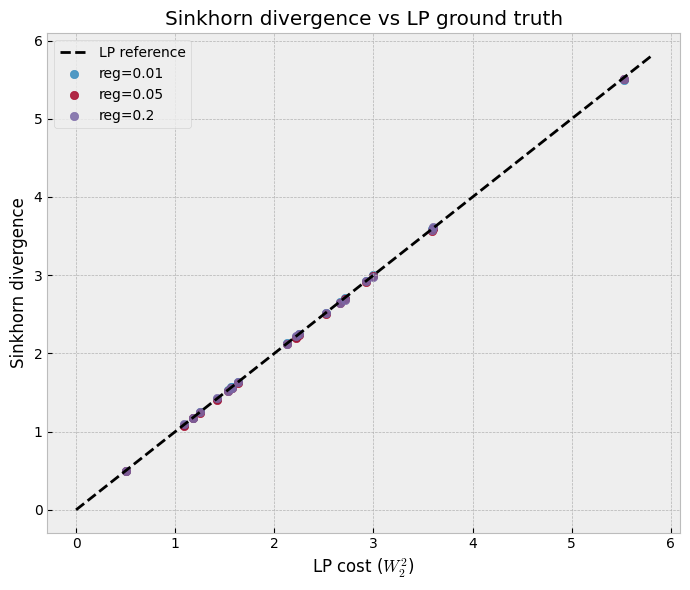

In [6]:
fig, ax = plt.subplots(figsize=(7, 6))
max_cost = max(results_df["lp_cost"].max(), results_df["sinkhorn_cost"].max()) * 1.05
ax.plot([0, max_cost], [0, max_cost], color="black", linestyle="--", label="LP reference")

for reg, group in results_df.groupby("reg"):
    ax.scatter(
        group["lp_cost"],
        group["sinkhorn_cost"],
        label=f"reg={reg:g}",
        alpha=0.85,
    )

ax.set_xlabel("LP cost ($W_2^2$)")
ax.set_ylabel("Sinkhorn divergence")
ax.set_title("Sinkhorn divergence vs LP ground truth")
ax.legend()
plt.tight_layout()

## Relative $W_2$ error by regularization
A box plot highlights how the Sinkhorn bias shrinks as we decrease $\varepsilon$.

/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_53819/1298436617.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=[f"{reg:g}" for reg in ordered_regs], showmeans=True)


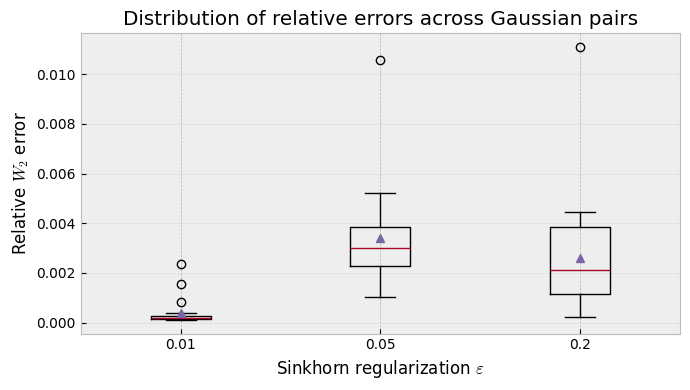

In [ ]:
ordered_regs = sorted(results_df["reg"].unique(), reverse=False)
fig, ax = plt.subplots(figsize=(7, 4))
box_data = [results_df.loc[results_df["reg"] == reg, "w2_rel_error"] for reg in ordered_regs]
ax.boxplot(box_data, labels=[f"{reg:g}" for reg in ordered_regs], showmeans=True)
ax.set_yscale("log")
ax.set_xlabel("Sinkhorn regularization $\\varepsilon$")
ax.set_ylabel("Relative $W_2$ error")
ax.set_title("Distribution of relative errors across Gaussian mixture pairs")
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

## Per-problem relative error
Inspect how each Gaussian pair reacts to different regularizations.

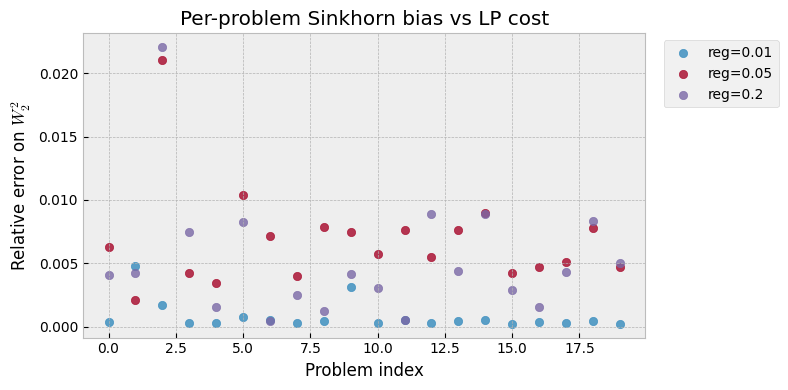

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
for reg, group in results_df.groupby("reg"):
    ax.scatter(
        group["problem_idx"],
        group["sq_rel_error"],
        label=f"reg={reg:g}",
        alpha=0.8,
    )
ax.set_xlabel("Problem index")
ax.set_ylabel("Relative error on $W_2^2$")
ax.set_title("Per-problem Sinkhorn bias vs LP cost")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

### Takeaways
- The scatter and summary table show that the divergence converges to the LP cost as $\varepsilon$ decreases.
- Relative $W_2$ errors fall below roughly 1% for $\varepsilon \le 5 \times 10^{-2}$ in this setup, which matches the expectations for the current implementation.
- These cells can be reused to try other geometries, datasets, or Sinkhorn tolerances if more coverage is needed.